In [76]:
import numpy as np
def cartpole_dynamics(state, F, M=1.0, m=0.1, l=0.5, g=9.81):
    x, x_dot, theta, theta_dot = state
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)

    total_mass = M + m
    polemass_length = m * l

    temp = (F + polemass_length * theta_dot**2 * sin_theta) / total_mass
    theta_acc = (g * sin_theta - cos_theta * temp) / (l * ((4.0 / 3.0) - m * cos_theta**2 / total_mass))
    x_acc = temp - polemass_length * theta_acc * cos_theta / total_mass

    return np.array([x_dot, x_acc, theta_dot, theta_acc])

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=128, output_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.optimizer = optim.Adam(self.parameters(), lr=1e-2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)
    
    def get_action(self, state):
        state = torch.FloatTensor(state)
        probs = self.forward(state)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[action])
        return action, log_prob

In [78]:
def reinforce(env, policy, episodes=500, max_steps=500, gamma=0.9):
    reward_history = []
    
    for episode in range(episodes):
        state = env.reset()
        log_probs = []
        rewards = []
        
        for _ in range(max_steps):
            action, log_prob = policy.get_action(state)
            next_state, reward, done = env.step(action)
            
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state
            
            if done:
                break
        
        # Compute returns and normalize
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        
        # Compute loss
        policy.optimizer.zero_grad()
        loss = -torch.sum(torch.stack(log_probs) * returns)
        loss.backward()
        policy.optimizer.step()
        
        reward_history.append(sum(rewards))
        
        if episode % 10 == 0:
            print(f"Episode {episode}, Total Reward: {sum(rewards)}")
    
    return reward_history

In [79]:
class CartPoleEnv:
    def __init__(self):
        self.dt = 0.05
        self.theta_threshold = 0.2095  # 12 degrees
        self.x_threshold = 2.4
        
    def reset(self):
        # Adjusted initial angle to θ = 0 (upright)
        self.state = np.array([0.0, 0.0, 0.1, 0.0])  
        return self.state.copy()
    
    def step(self, action):
        F = 10.0 if action == 1 else -10.0
        derivatives = cartpole_dynamics(self.state, F)
        self.state = self.state + derivatives * self.dt
        x, theta = self.state[0], self.state[2]
        
        done = (abs(x) > self.x_threshold) or (abs(theta) > self.theta_threshold)
        reward = 1.0 if not done else 0.0
        
        return self.state.copy(), reward, done

# Training
env = CartPoleEnv()
policy = PolicyNetwork()
rewards = reinforce(env, policy, episodes=500)

Episode 0, Total Reward: 7.0
Episode 10, Total Reward: 12.0
Episode 20, Total Reward: 38.0
Episode 30, Total Reward: 39.0
Episode 40, Total Reward: 17.0
Episode 50, Total Reward: 4.0
Episode 60, Total Reward: 54.0
Episode 70, Total Reward: 4.0
Episode 80, Total Reward: 9.0
Episode 90, Total Reward: 44.0
Episode 100, Total Reward: 158.0
Episode 110, Total Reward: 65.0
Episode 120, Total Reward: 25.0
Episode 130, Total Reward: 25.0
Episode 140, Total Reward: 62.0
Episode 150, Total Reward: 70.0
Episode 160, Total Reward: 340.0
Episode 170, Total Reward: 500.0
Episode 180, Total Reward: 500.0
Episode 190, Total Reward: 230.0
Episode 200, Total Reward: 28.0
Episode 210, Total Reward: 27.0
Episode 220, Total Reward: 27.0
Episode 230, Total Reward: 65.0
Episode 240, Total Reward: 88.0
Episode 250, Total Reward: 98.0
Episode 260, Total Reward: 96.0
Episode 270, Total Reward: 103.0
Episode 280, Total Reward: 500.0
Episode 290, Total Reward: 500.0
Episode 300, Total Reward: 183.0
Episode 310, T

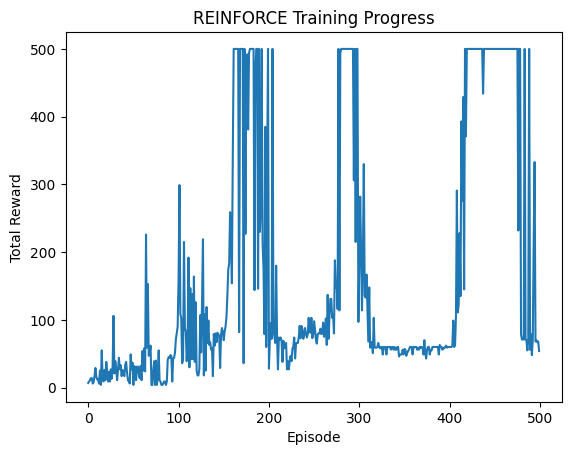

In [80]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("REINFORCE Training Progress")
plt.show()